This script uses vectorized transcripts to analyze and group the similar videos together.
- Apply K-means to separate video category
- Find the video category from Youtube API
- For each video category, we recommend several channels based on users requirements:
- Channel information: 'topic_categories', 'total_views', 'subscribers', 'hidden_subscribers', 'videos'

In [217]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

import os
import pandas as pd
import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from DocSim import DocSim


from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

### Word2Vec

In [14]:
model = Word2Vec.load('full_word2vec.model')
word_vectors = model.wv

In [3]:
word_vectors.most_similar("obama")

[('biden_barack', 0.7179836630821228),
 ('nipple_snowman', 0.6905137896537781),
 ('president_barack', 0.658582866191864),
 ('obama_obama', 0.6298388838768005),
 ('vote_barack', 0.610968828201294),
 ('elect_barack', 0.6092473268508911),
 ('44th_president', 0.5893622636795044),
 ('obama_barack', 0.5891886949539185),
 ('barack_obama', 0.578271210193634),
 ('obama_michelle', 0.577674388885498)]

In [15]:
path = os.getcwd()
src_folder = os.path.abspath(os.path.join(path, os.pardir))
project_folder = os.path.abspath(os.path.join(src_folder, os.pardir))
outside_folder = os.path.abspath(os.path.join(project_folder, os.pardir))
data_folder = outside_folder + '/sb-mirror'
processed_sponsor_df = pd.read_csv(data_folder + '/transcript_topic_statistic.csv', index_col=[0])

In [47]:
processed_sponsor_df['transcript_list'] = processed_sponsor_df['processed_transcript'].apply(lambda elem: elem.strip('][').replace('\'', '').replace(',', ''))
#processed_sponsor_df['topic_list'] = processed_sponsor_df['topics'].apply(lambda elem: elem.strip('][').replace("'", "").split(', ')) 
processed_sponsor_df.head()

,videoID,Transcript,channelID,title,published,sponsored,processed_transcript,total_views,subscribers,hidden_subscribers,num_videos,topics,transcript_list
0,6CJrIhsR23I,Tyva.. Many in Russia do not even \nknow about...,UC101o-vQ2iOj9vr00JUlyKw,"Тыва: шаманизм, национализм и алкоголизм | Без...",1.623715e+09,True,"['tyva', 'russia', 'know', 'region', 'republic...",1.355656e+09,4150000.0,False,1675.0,"['Politics', 'Society']",tyva russia know region republic south siberia...
1,7bn8hM9k0b0,[Garbled mumbling]. [Low scream that rises in ...,UCo_IB5145EVNcf8hw1Kku7w,"Game Theory: FNAF, You Were Meant To Lose (FNA...",1.559952e+09,True,"['garbled', 'mumbling', 'scream', 'rise', 'vol...",3.585529e+09,17200000.0,False,606.0,"['Action_game', 'Action-adventure_game', 'Vide...",garbled mumbling scream rise volume mumbling i...
2,7Z5D9OYb_Os,so. you think you've got what it takes. they c...,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Respawn Are Testing Titans In Apex Legends Sea...,1.636848e+09,True,"['think', 'apex', 'legend', 'people', 'complet...",4.994942e+07,196000.0,False,930.0,"['Role-playing_video_game', 'Action-adventure_...",think apex legend people completely literal me...
3,BeyWAVwl6eE,hi how are you matt watson here from car. wow ...,UCUhFaUpnq31m6TNX2VKVSVA,Lamborghini Aventador SV vs £1M Rallycross Rac...,1.623456e+09,True,"['matt', 'watson', 'yanny', 'janomer', 'lambor...",3.077021e+09,7970000.0,False,2113.0,"['Lifestyle_(sociology)', 'Motorsport', 'Vehic...",matt watson yanny janomer lamborghini inventor...
4,3HOuBTGabI4,we've always used social media as a way. to es...,UCN5xN8gIljvWYnsj06V8WbQ,Logan Paul's first movie is worse than you can...,1.615939e+09,True,"['social', 'medium', 'escape', 'mundane', 'pre...",1.495206e+09,4760000.0,False,657.0,"['Action_game', 'Role-playing_video_game', 'En...",social medium escape mundane pretend come phot...


In [42]:
processed_sponsor_df['topic_list'][0]

"['Politics', 'Society']"

In [17]:
word_vectors.most_similar(positive=['coffee'])

[('coffee_coffee', 0.7373400926589966),
 ('drink_coffee', 0.6733774542808533),
 ('coffee_starbuck', 0.650966465473175),
 ('instant_coffee', 0.6388344168663025),
 ('coffee_bean', 0.6290655732154846),
 ('coffee_espresso', 0.6262529492378235),
 ('freshly_roast', 0.624765157699585),
 ('brew_coffee', 0.6237855553627014),
 ('freshly_brew', 0.6177647709846497),
 ('espresso_espresso', 0.6162578463554382)]

I want to find a youtuber that introduce coffee and it's better if they have at least 100000 subscribers

In [48]:
ds = DocSim(model.wv)

In [65]:
source_doc = 'coffee'
target_docs = list(processed_sponsor_df['transcript_list'][0:100])

# This will return 100 target docs with similarity score
sim_scores = ds.calculate_similarity(source_doc, target_docs, 0.3)

### Filter data

In [225]:
topics = []
for i in range(len(processed_sponsor_df)):
    try:
        topic_list = processed_sponsor_df['topics'][i].strip("[]").replace("'", '').split(',')
    except AttributeError:
        topic_list = ['no topics']
    topics.append(topic_list)

In [226]:
processed_sponsor_df['topic_list'] = pd.Series(topics)

In [227]:
topic_df = pd.DataFrame(processed_sponsor_df['topic_list'].tolist())
topic_df = topic_df.add_prefix('topic_')

In [228]:
final_df = pd.concat([processed_sponsor_df, topic_df], axis=1)
final_df.head()

,videoID,Transcript,channelID,title,published,sponsored,processed_transcript,total_views,subscribers,hidden_subscribers,...,topic_list,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,6CJrIhsR23I,Tyva.. Many in Russia do not even \nknow about...,UC101o-vQ2iOj9vr00JUlyKw,"Тыва: шаманизм, национализм и алкоголизм | Без...",1.623715e+09,True,"['tyva', 'russia', 'know', 'region', 'republic...",1.355656e+09,4150000.0,False,...,"[Politics, Society]",Politics,Society,None,None,None,None,None,None,None
1,7bn8hM9k0b0,[Garbled mumbling]. [Low scream that rises in ...,UCo_IB5145EVNcf8hw1Kku7w,"Game Theory: FNAF, You Were Meant To Lose (FNA...",1.559952e+09,True,"['garbled', 'mumbling', 'scream', 'rise', 'vol...",3.585529e+09,17200000.0,False,...,"[Action_game, Action-adventure_game, Video_g...",Action_game,Action-adventure_game,Video_game_culture,Role-playing_video_game,None,None,None,None,None
2,7Z5D9OYb_Os,so. you think you've got what it takes. they c...,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Respawn Are Testing Titans In Apex Legends Sea...,1.636848e+09,True,"['think', 'apex', 'legend', 'people', 'complet...",4.994942e+07,196000.0,False,...,"[Role-playing_video_game, Action-adventure_ga...",Role-playing_video_game,Action-adventure_game,Video_game_culture,Action_game,Strategy_video_game,None,None,None,None
3,BeyWAVwl6eE,hi how are you matt watson here from car. wow ...,UCUhFaUpnq31m6TNX2VKVSVA,Lamborghini Aventador SV vs £1M Rallycross Rac...,1.623456e+09,True,"['matt', 'watson', 'yanny', 'janomer', 'lambor...",3.077021e+09,7970000.0,False,...,"[Lifestyle_(sociology), Motorsport, Vehicle]",Lifestyle_(sociology),Motorsport,Vehicle,None,None,None,None,None,None
4,3HOuBTGabI4,we've always used social media as a way. to es...,UCN5xN8gIljvWYnsj06V8WbQ,Logan Paul's first movie is worse than you can...,1.615939e+09,True,"['social', 'medium', 'escape', 'mundane', 'pre...",1.495206e+09,4760000.0,False,...,"[Action_game, Role-playing_video_game, Enter...",Action_game,Role-playing_video_game,Entertainment,Video_game_culture,Action-adventure_game,None,None,None,None


In [229]:
filter_topics_df = final_df[final_df['topic_0'].str.contains("video_game")|
                            final_df['topic_1'].str.contains("video_game")|
                            final_df['topic_2'].str.contains("video_game")|
                            final_df['topic_3'].str.contains("video_game")|
                            final_df['topic_4'].str.contains("video_game")|
                            final_df['topic_5'].str.contains("video_game")|
                            final_df['topic_6'].str.contains("video_game")|
                            final_df['topic_7'].str.contains("video_game")|
                            final_df['topic_8'].str.contains("video_game")]

In [230]:
filter_topics_df = filter_topics_df.drop_duplicates(subset=['channelID'])
filter_topics_df 

,videoID,Transcript,channelID,title,published,sponsored,processed_transcript,total_views,subscribers,hidden_subscribers,...,topic_list,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
1,7bn8hM9k0b0,[Garbled mumbling]. [Low scream that rises in ...,UCo_IB5145EVNcf8hw1Kku7w,"Game Theory: FNAF, You Were Meant To Lose (FNA...",1.559952e+09,True,"['garbled', 'mumbling', 'scream', 'rise', 'vol...",3.585529e+09,17200000.0,False,...,"[Action_game, Action-adventure_game, Video_g...",Action_game,Action-adventure_game,Video_game_culture,Role-playing_video_game,None,None,None,None,None
2,7Z5D9OYb_Os,so. you think you've got what it takes. they c...,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Respawn Are Testing Titans In Apex Legends Sea...,1.636848e+09,True,"['think', 'apex', 'legend', 'people', 'complet...",4.994942e+07,196000.0,False,...,"[Role-playing_video_game, Action-adventure_ga...",Role-playing_video_game,Action-adventure_game,Video_game_culture,Action_game,Strategy_video_game,None,None,None,None
4,3HOuBTGabI4,we've always used social media as a way. to es...,UCN5xN8gIljvWYnsj06V8WbQ,Logan Paul's first movie is worse than you can...,1.615939e+09,True,"['social', 'medium', 'escape', 'mundane', 'pre...",1.495206e+09,4760000.0,False,...,"[Action_game, Role-playing_video_game, Enter...",Action_game,Role-playing_video_game,Entertainment,Video_game_culture,Action-adventure_game,None,None,None,None
6,A4i6Og7Itpg,hello everyone this is da rule 20 and. this is...,UC_ViSsVg_3JUDyLS3E2Un5g,Sevtech Ages Ep1 New Beginnings,1.522454e+09,True,"['hello', 'rule', 'poha', 'marner', 'pommard',...",3.432897e+08,515000.0,False,...,"[Action_game, Strategy_video_game, Action-ad...",Action_game,Strategy_video_game,Action-adventure_game,Video_game_culture,Role-playing_video_game,None,None,None,None
7,IvWxWYeCarQ,hey guys sean dubs here so 343 just. shared so...,UCTeyrYVDyVeyy0V3t3_tJpQ,343 Finally Responds to Lack of Halo Infinite ...,1.638490e+09,True,"['sean', 'share', 'news', 'playlist', 'come', ...",2.147086e+07,76700.0,False,...,"[Video_game_culture, Action-adventure_game, ...",Video_game_culture,Action-adventure_game,Action_game,Strategy_video_game,Role-playing_video_game,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101149,Aql-23GwJPs,[Music]. [Music]. three two one. [Music]. [Mus...,UCQ-aT1kd8YsTOzAuWIabk9Q,Ejected But Every turn a different character i...,1.634774e+09,True,"['music', 'music', 'music', 'music', 'music', ...",2.379600e+04,180.0,False,...,"[Music_video_game, Action_game, Video_game_c...",Music_video_game,Action_game,Video_game_culture,Action-adventure_game,None,None,None,None,None
101154,tKteUO3KaXA,alchemy the science of understanding. deconstr...,UCpDQzKzLu--9M67H5Bprd1g,Alchemy Guide - Idleon,1.609286e+09,True,"['alchemy', 'science', 'understanding', 'decon...",2.099835e+06,17500.0,False,...,"[Strategy_video_game, Action_game, Action-ad...",Strategy_video_game,Action_game,Action-adventure_game,Role-playing_video_game,Video_game_culture,None,None,None,None
101159,qtFOgmveJBo,what's up guys blitz here today bringing. you ...,UCzsJLyYOl-6idSCmvjs1K4w,NEW Final Fantasy 7 RELEASE DATE?! & TFS Conte...,1.635379e+09,True,"['blitz', 'today', 'bring', 'video', 'today', ...",1.924895e+07,109000.0,False,...,"[Action_game, Action-adventure_game, Strateg...",Action_game,Action-adventure_game,Strategy_video_game,Role-playing_video_game,Video_game_culture,None,None,None,None
101176,jFUEVrsTGNs,while the english-speaking world hasn't. reall...,UCpzDkZqC_FfutnGpjbvvUvQ,The Overlooked Version of Dragon Quest X Online,1.623110e+09,True,"['english', 'speak', 'world', 'opportunity', '...",1.488418e+06,3470.0,False,...,"[Video_game_culture, Action-adventure_game, ...",Video_game_culture,Action-adventure_game,Strategy_video_game,Action_game,Sports_game,Role-playing_video_game,None,None,None


In [215]:
filter_subscribers_df = filter_topics_df[(filter_topics_df['subscribers'] >= 10000) & 
                                         (filter_topics_df['num_videos'] >=20) &
                                         (filter_topics_df['total_views'] >= 10000000)]
filter_subscribers_df

,videoID,Transcript,channelID,title,published,sponsored,processed_transcript,total_views,subscribers,hidden_subscribers,...,topic_list,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
1,7bn8hM9k0b0,[Garbled mumbling]. [Low scream that rises in ...,UCo_IB5145EVNcf8hw1Kku7w,"Game Theory: FNAF, You Were Meant To Lose (FNA...",1.559952e+09,True,"['garbled', 'mumbling', 'scream', 'rise', 'vol...",3.585529e+09,17200000.0,False,...,"[Action_game, Action-adventure_game, Video_g...",Action_game,Action-adventure_game,Video_game_culture,Role-playing_video_game,None,None,None,None,None
2,7Z5D9OYb_Os,so. you think you've got what it takes. they c...,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Respawn Are Testing Titans In Apex Legends Sea...,1.636848e+09,True,"['think', 'apex', 'legend', 'people', 'complet...",4.994942e+07,196000.0,False,...,"[Role-playing_video_game, Action-adventure_ga...",Role-playing_video_game,Action-adventure_game,Video_game_culture,Action_game,Strategy_video_game,None,None,None,None
4,3HOuBTGabI4,we've always used social media as a way. to es...,UCN5xN8gIljvWYnsj06V8WbQ,Logan Paul's first movie is worse than you can...,1.615939e+09,True,"['social', 'medium', 'escape', 'mundane', 'pre...",1.495206e+09,4760000.0,False,...,"[Action_game, Role-playing_video_game, Enter...",Action_game,Role-playing_video_game,Entertainment,Video_game_culture,Action-adventure_game,None,None,None,None
6,A4i6Og7Itpg,hello everyone this is da rule 20 and. this is...,UC_ViSsVg_3JUDyLS3E2Un5g,Sevtech Ages Ep1 New Beginnings,1.522454e+09,True,"['hello', 'rule', 'poha', 'marner', 'pommard',...",3.432897e+08,515000.0,False,...,"[Action_game, Strategy_video_game, Action-ad...",Action_game,Strategy_video_game,Action-adventure_game,Video_game_culture,Role-playing_video_game,None,None,None,None
7,IvWxWYeCarQ,hey guys sean dubs here so 343 just. shared so...,UCTeyrYVDyVeyy0V3t3_tJpQ,343 Finally Responds to Lack of Halo Infinite ...,1.638490e+09,True,"['sean', 'share', 'news', 'playlist', 'come', ...",2.147086e+07,76700.0,False,...,"[Video_game_culture, Action-adventure_game, ...",Video_game_culture,Action-adventure_game,Action_game,Strategy_video_game,Role-playing_video_game,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100877,TF_zTD7DuyM,i love you brim. nice playing with you all hav...,UCCBJqqk5h2hh8_WDGzrkRCQ,meeting the brimstone voice actor in valorant,1.629504e+09,True,"['love', 'brim', 'nice', 'playing', 'good', 'n...",5.386643e+07,277000.0,False,...,"[Action_game, Role-playing_video_game, Video...",Action_game,Role-playing_video_game,Video_game_culture,None,None,None,None,None,None
100887,HljvNxOd9zY,so am i quitting youtube is this the. final vi...,UC8W2N2cHaAxvp89sMYMNB5w,stepping down...,1.636070e+09,True,"['quit', 'youtube', 'final', 'video', 'super',...",6.804552e+07,194000.0,False,...,"[Action_game, Video_game_culture, Action-adv...",Action_game,Video_game_culture,Action-adventure_game,Role-playing_video_game,None,None,None,None,None
100897,9rZ_cZRWV54,as of this moment my program is. reactivated a...,UCBJ4RpQPQutOnWcqiooL9eQ,R6 SIEGE HETKET & TILANTEET,1.448928e+09,True,"['moment', 'program', 'reactivate', 'head', 'c...",1.136121e+08,291000.0,False,...,"[Action-adventure_game, Role-playing_video_ga...",Action-adventure_game,Role-playing_video_game,Strategy_video_game,Action_game,Video_game_culture,None,None,None,None
101131,WmZMuD0_F-o,yo hello sir are you happen to be friendly \nm...,UCq9S9hjfdt0rOudr6sxTp6g,Raiding RACIST TEAM & Making Them RAGE QUIT,1.636070e+09,True,"['hello', 'happen', 'friendly', 'team', 'okay'...",5.001710e+07,227000.0,False,...,"[Action_game, Action-adventure_game, Role-pl...",Action_game,Action-adventure_game,Role-playing_video_game,Video_game_culture,None,None,None,None,None


#### want to find sepecific thing

### Kmeans
#### Kmeans is not working for topics: a lot of overlaps

In [116]:
 #changing to numerical by label encoder
label_encoder = LabelEncoder()
for i in range(len(topic_df.columns)):
    final_df[f"topic_{i}"] = label_encoder.fit_transform(final_df[f"topic_{i}"])

In [118]:
final_df.head()

,videoID,Transcript,channelID,title,published,sponsored,processed_transcript,total_views,subscribers,hidden_subscribers,...,topic_list,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,6CJrIhsR23I,Tyva.. Many in Russia do not even \nknow about...,UC101o-vQ2iOj9vr00JUlyKw,"Тыва: шаманизм, национализм и алкоголизм | Без...",1.623715e+09,True,"['tyva', 'russia', 'know', 'region', 'republic...",1.355656e+09,4150000.0,False,...,"[Politics, Society]",35,44,55,52,43,29,21,9,2
1,7bn8hM9k0b0,[Garbled mumbling]. [Low scream that rises in ...,UCo_IB5145EVNcf8hw1Kku7w,"Game Theory: FNAF, You Were Meant To Lose (FNA...",1.559952e+09,True,"['garbled', 'mumbling', 'scream', 'rise', 'vol...",3.585529e+09,17200000.0,False,...,"[Action_game, Action-adventure_game, Video_g...",12,0,54,38,43,29,21,9,2
2,7Z5D9OYb_Os,so. you think you've got what it takes. they c...,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Respawn Are Testing Titans In Apex Legends Sea...,1.636848e+09,True,"['think', 'apex', 'legend', 'people', 'complet...",4.994942e+07,196000.0,False,...,"[Role-playing_video_game, Action-adventure_ga...",44,0,54,1,38,29,21,9,2
3,BeyWAVwl6eE,hi how are you matt watson here from car. wow ...,UCUhFaUpnq31m6TNX2VKVSVA,Lamborghini Aventador SV vs £1M Rallycross Rac...,1.623456e+09,True,"['matt', 'watson', 'yanny', 'janomer', 'lambor...",3.077021e+09,7970000.0,False,...,"[Lifestyle_(sociology), Motorsport, Vehicle]",21,22,53,52,43,29,21,9,2
4,3HOuBTGabI4,we've always used social media as a way. to es...,UCN5xN8gIljvWYnsj06V8WbQ,Logan Paul's first movie is worse than you can...,1.615939e+09,True,"['social', 'medium', 'escape', 'mundane', 'pre...",1.495206e+09,4760000.0,False,...,"[Action_game, Role-playing_video_game, Enter...",12,42,6,50,0,29,21,9,2


In [120]:
selected_topic_df = final_df[['videoID', 
                              'channelID',
                              'topic_0',
                              'topic_1',
                              'topic_2',
                              'topic_3',
                              'topic_4',
                              'topic_5',
                              'topic_6',
                              'topic_7',
                              'topic_8']]

In [125]:
X = selected_topic_df.iloc[:, 2:]
X

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,35,44,55,52,43,29,21,9,2
1,12,0,54,38,43,29,21,9,2
2,44,0,54,1,38,29,21,9,2
3,21,22,53,52,43,29,21,9,2
4,12,42,6,50,0,29,21,9,2
...,...,...,...,...,...,...,...,...,...
101257,12,0,54,52,43,29,21,9,2
101258,58,42,0,1,43,29,21,9,2
101259,15,19,55,52,43,29,21,9,2
101260,21,13,55,52,43,29,21,9,2



#### Elbow Method For Optimal k'

In [137]:
import warnings
warnings.filterwarnings('ignore')

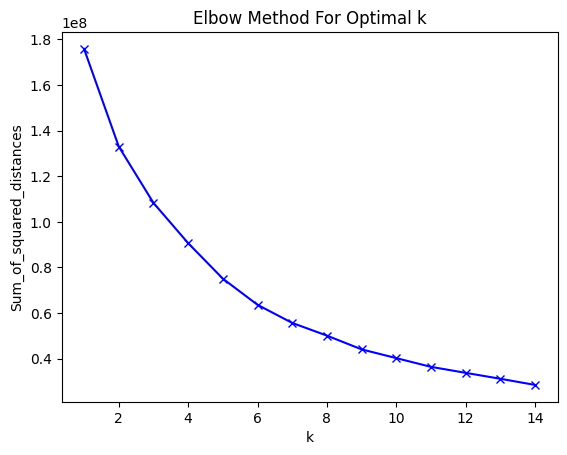

In [138]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [130]:
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
y_kmeans = kmeans.fit_predict(X)

/Users/jinlingxing/Projects/Kaggle/video_sponsorship_detection/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [133]:
set(y_kmeans)

{0, 1, 2, 3, 4, 5, 6, 7}

In [153]:
centers = kmeans.cluster_centers_
centers

array([[22.15959729, 48.27694339, 44.37349398,  3.52087803, 29.45089949,
        26.80722892, 20.92622545,  8.97870936,  2.        ],
       [13.3620624 , 10.25352411, 48.44736062, 50.42653346, 42.46412395,
        28.81369851, 20.99225331,  8.99889938,  2.        ],
       [15.43747656, 45.44632811,  9.43072538, 47.72252644, 38.97142   ,
        28.23614132, 20.91448503,  8.99842472,  1.99684945],
       [46.62653717, 11.08968434,  8.60546722, 47.4771677 , 38.26537166,
        28.24030704, 20.90624266,  9.        ,  2.        ],
       [25.43797049, 51.8166215 , 53.54918197, 51.05736224, 40.15517414,
        28.55264479, 20.98599819,  8.99924721,  2.        ],
       [51.14217515, 17.39773236, 52.58593167, 50.23496942, 37.63120991,
        28.58555871, 20.94659108,  8.99932866,  2.        ],
       [45.67137331, 47.86247582,  3.2615087 ,  6.49767892, 36.32475822,
        26.62940039, 20.72359768,  8.99651838,  2.        ],
       [36.52994269,  6.41103152, 38.35286533,  5.46962751, 39

In [160]:
kmeans.labels_ 

array([2, 4, 7, ..., 4, 4, 4], dtype=int32)

In [158]:
#predict the labels of clusters.
label = kmeans.fit_predict(X)

In [161]:
X_fit = kmeans.fit_transform(X)
X_fit

array([[31.69527198, 39.74713747, 59.47742958, ..., 57.49984526,
        50.0001484 , 62.37513581],
       [44.91073826, 16.49456674, 63.12320289, ..., 42.60915322,
        68.21555225, 45.43455403],
       [52.74135724, 59.06767708, 66.16763884, ..., 68.78311759,
        86.01655605, 14.76418065],
       ...,
       [36.70036843,  9.15117299, 60.73791517, ..., 42.56408926,
        55.77996967, 56.51945688],
       [31.08539743,  8.3533354 , 56.8860215 , ..., 42.44414544,
        59.38517699, 53.10985712],
       [44.46726209, 14.75419229, 54.54082354, ..., 30.59156728,
        60.2613183 , 53.53727788]])

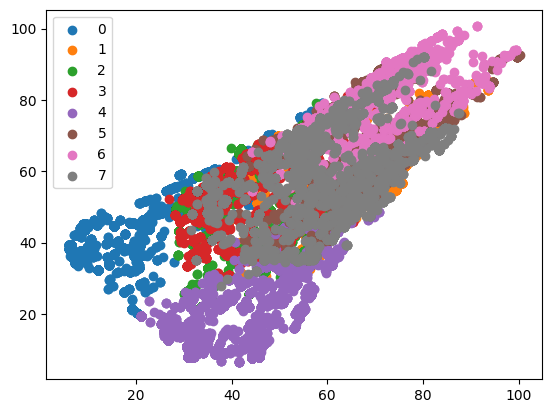

In [170]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X_fit[label == i , 0] ,X_fit[label == i , 1] , label = i)
plt.legend()
plt.show()